# Gaussian filter python

In [1]:
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.ndimage.filters import gaussian_filter1d, gaussian_filter
%matplotlib inline

In [2]:
# function input
truncate = 4.
sigma = 4.
imagename = 'small.png'

In [3]:
# get ideal side sizes from arguments
lw = int(truncate*sigma+0.5)
pan = 2*lw+1

# for now we take values on the right until it fills a multiple of 8
# AVX is in x direction (in the matrix)
span = (pan // 8 + 1) * 8

# load image (only one color now)
f = misc.imread(imagename)
f = f[:,:,0]
output = f*0.

# add span-1 the -1 is because there is always at least one from the original image
lx, ly = f.shape
spx, spy = np.array([lx + span-1, ly + pan-1])

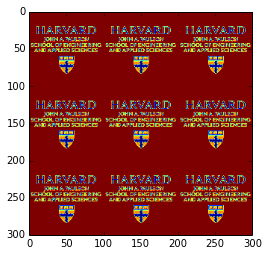

In [4]:
# add halo (periodic boundary condition, we could do something better but we don't have time to mess around with indexes...)
input = np.zeros((3*lx,3*ly))
for i in range(3):
    for j in range(3):
            input[i*lx:(i+1)*lx, j*ly:(j+1)*ly] = f

plt.imshow(input)

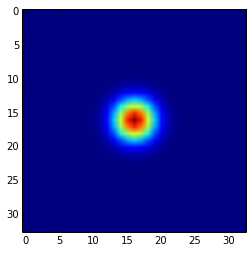

In [5]:
gaussianfilter = np.zeros((pan,pan))
for i in range(0,lw+1):
    for j in range(0,lw+1):
        gaussianfilter[i+lw,j+lw] = np.linalg.norm([i,j])
        gaussianfilter[-i+lw,-j+lw] = np.linalg.norm([i,j])
        gaussianfilter[-i+lw,j+lw] = np.linalg.norm([i,j])
        gaussianfilter[i+lw,-j+lw] = np.linalg.norm([i,j])
        
gaussianfilter = np.array(gaussianfilter)
gaussianfilter **= 2
gaussianfilter *= -.5/sigma
gaussianfilter = np.exp(gaussianfilter)
gaussianfilter /= np.sum(gaussianfilter)
plt.imshow(gaussianfilter)

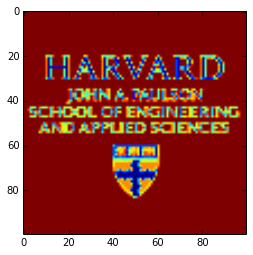

In [6]:
plt.imshow(input[lx:2*lx, ly:2*ly])

192.510941492


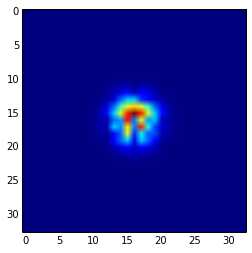

In [7]:
i = lx + 50
j = ly + 35
local_input = input[i-lw:i+lw+1, j-lw:j+lw+1]
plt.imshow(local_input*gaussianfilter)
print np.sum(local_input*gaussianfilter)

python 0.559754133224


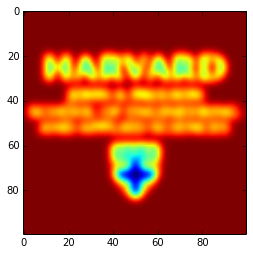

In [24]:
output_ini = output * 0
start = time.time()
for i in range(lx,2*lx):
    for j in range(ly,2*ly):
        local_input = input[i-lw:i+lw+1, j-lw:j+lw+1]
        output_ini[i-lx,j-ly]= np.sum(local_input*gaussianfilter)
plt.imshow(output_ini)
print "python", time.time() - start

scipy 0.15003490448


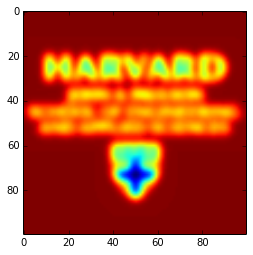

In [19]:
start = time.time()
blur = gaussian_filter(f, 2)
plt.imshow(blur)
print "scipy", time.time() - start

---

## Transition to AVX algorithm

Instead of precomputing the gaussian kernel, we will compute it for each pixel.
The python code will be much slower. However, when going parallel, it will limit the amount of data to move. There will also be no work around when transitioning to bilateral filter when the weight in every pixel is different.

computing one line each time

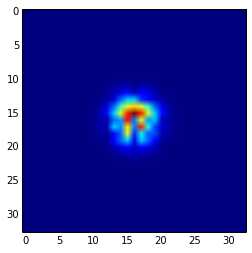

In [10]:
i = lx + 50
j = ly + 35
local_input = input[i-lw:i+lw+1, j-lw:j+lw+1]
toplot = local_input*0
sumg = 0

for k in range(pan):
    gaussian = [np.exp(-.5/sigma*np.linalg.norm([k-lw,_])**2) for _ in range(-lw,lw+1)]
    toplot[k,:] = local_input[k,:] * gaussian
    sumg += np.sum(gaussian)

toplot /= sumg
plt.imshow(toplot)

multiple of 8 (this one took long to do it right...)

Here we introduce the 8-parallelism that suits AVX well.

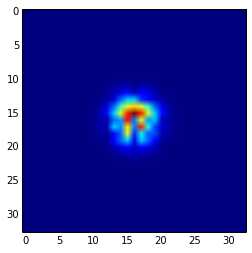

In [11]:
i = lx + 50
j = ly + 35
local_input = input[i-lw:i+lw+1, j-lw:j+lw+1]
toplot = local_input*0
sumg = 0

for k in range(pan):
    gaussianc = np.exp(-.5/sigma*np.linalg.norm([k-lw,0])**2)
    sumg += gaussianc
    toplot[k,lw] = local_input[k,lw] * gaussianc
    for l in range(1, lw+1, 8):
        toplot[k,lw+l:lw+l+8] = [local_input[k,lw+_]*np.exp(-.5/sigma*np.linalg.norm([k-lw,_])**2) for _ in range(l,l+8)]
        gaussianl = [np.exp(-.5/sigma*np.linalg.norm([k-lw,_])**2) for _ in range(l,l+8)]
        sumg += np.sum(gaussianl)
    for l in range(0, lw, 8):
        toplot[k,l:l+8] = [local_input[k,_]*np.exp(-.5/sigma*np.linalg.norm([k-lw,_-lw])**2) for _ in range(l,l+8)]
        gaussianr = [np.exp(-.5/sigma*np.linalg.norm([k-lw,_-lw])**2) for _ in range(l,l+8)]
        sumg += np.sum(gaussianr)

toplot /= sumg
plt.imshow(toplot)

Keep:

truncate = 4.

sigma = 4.

For now. This way I don't need to care about boundary pb.

python AVX algorithm 496.191529989


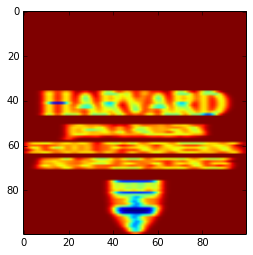

In [12]:
output *= 0

start = time.time()

for i in range(lx,2*lx):
    for j in range(ly,2*ly):
        sumg = 0
        local_input = input[i-lw:i+lw+1, j-lw:j+lw+1]
        for k in range(pan):
            coef = np.exp(-.5/sigma*np.linalg.norm([k-lw,0])**2)
            output[i-lx,j-ly] += local_input[k,lw] * coef
            sumg += coef
            for l in range(1, lw+1, 8):
                for _ in range(l,l+8):
                    coef = np.exp(-.5/sigma*np.linalg.norm([k-lw,_])**2)
                    output[i-lx,j-ly] += local_input[k,lw+_] * coef
                    sumg += coef
            for l in range(0, lw, 8):
                for _ in range(l,l+8):
                    coef = np.exp(-.5/sigma*np.linalg.norm([k-lw,_-lw])**2)
                    output[i-lx,j-ly] += local_input[k,_] * coef
                    sumg += coef
            output[i-lx,j-ly]/= sumg

output /= sumg
# plt.imshow(output)
print "python AVX algorithm", time.time() - start

The AVX algorithm is way worse in performance, if we keep using pure python.
The python code is buggy but the cython code works perfectly so we move on.

4 orders of magnitude slower!

---

-  Cython implementation to be debugged: no array comprehension in cython

Cython gaussian serial:

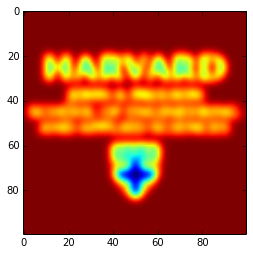

In [25]:
# solution from cython
import numpy as np
A = np.genfromtxt("foo.csv", delimiter="," )

import matplotlib.pyplot as plt
plt.imshow(A)
plt.show()

<matplotlib.colorbar.Colorbar instance at 0x7f29c16e91b8>

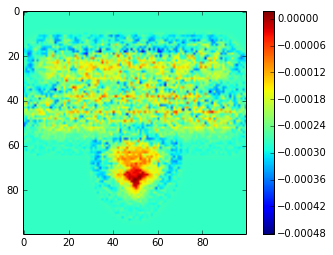

In [26]:
plt.imshow(A-output)
plt.colorbar()

---

## Bilateral filter

From [Wikipedia](https://en.wikipedia.org/wiki/Bilateral_filter)

The Bilateral filter has this formula:

$$I^\text{filtered}(x) = \frac{1}{W_p} \sum_{x_i \in \Omega} I(x_i)f_r(\|I(x_i)-I(x)\|)g_s(\|x_i-x\|)$$

Here we take $f_r$ and $g_s$ to be the same Gaussian distribution

We need to compute the normalization within the loops


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:33: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:33: RuntimeWarning: overflow encountered in double_scalars


python bilateral AVX algorithm 1145.23798418


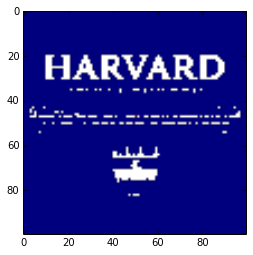

In [13]:
output *= 0

start = time.time()
        
for i in range(lx,2*lx):
    for j in range(ly,2*ly):
        sumg = 0
        local_input = input[i-lw:i+lw+1, j-lw:j+lw+1]
        I = local_input[lw,lw]

        for k in range(pan):
            gaussianc = np.exp(-.5/sigma*np.linalg.norm([k-lw,0])**2) * np.exp(-.5/sigma*abs(local_input[k,lw]-I)**2)
            sumg += gaussianc
            output[i-lx,j-ly] += local_input[k,lw] * gaussianc
            for l in range(1, lw+1, 8):
                output[i-lx,j-ly] += np.sum([local_input[k,lw+_]*
                                             np.exp(-.5/sigma*np.linalg.norm([k-lw,_])**2)*
                                             np.exp(-.5/sigma*abs(local_input[k,lw+_]-I)**2)
                                             for _ in range(l,l+8)])
                gaussianl = [np.exp(-.5/sigma*np.linalg.norm([k-lw,_])**2)*
                             np.exp(-.5/sigma*abs(local_input[k,lw+_]-I)**2)
                             for _ in range(l,l+8)]
                sumg += np.sum(gaussianl)
            for l in range(0, lw, 8):
                output[i-lx,j-ly] += np.sum([local_input[k,_]*
                                             np.exp(-.5/sigma*np.linalg.norm([k-lw,_-lw])**2)*
                                             np.exp(-.5/sigma*abs(local_input[k,_]-I)**2)
                                             for _ in range(l,l+8)])
                gaussianr = [np.exp(-.5/sigma*np.linalg.norm([k-lw,_-lw])**2)*
                             np.exp(-.5/sigma*abs(local_input[k,_]-I)**2)
                             for _ in range(l,l+8)]
                sumg += np.sum(gaussianr)
            output[i-lx,j-ly]/= sumg
        
# plt.imshow(output)
print "python bilateral AVX algorithm", time.time() - start

The python code is buggy but the cython code works perfectly so we move on.

Cython bilateral serial:

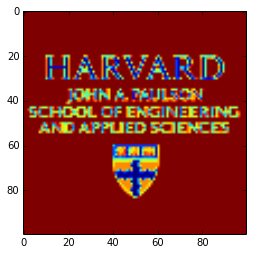

In [27]:
# solution from cython
import numpy as np
A = np.genfromtxt("foo2.csv", delimiter="," )

import matplotlib.pyplot as plt
plt.imshow(A)
plt.show()

---

##TODO

cython:
    
- declare _
- change norm([i,j]) with (i*i+j*j)
- debug prange

Avx:

- setup exp function
- code in avx

Also:

- adapt for halo that not multiple of 8
- adapt with smaller input
